In [1]:
from serial import Serial
from pyubx2 import UBXReader,UBXMessage
import csv
import numpy as np
import pandas as pd
from astropy.coordinates import EarthLocation, SkyCoord
from astropy import units as u
# Plotting and interactive packages
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
# Cryptographic packages
from hashlib import sha256
import ecdsa
import hmac
import base64
import socket
# Append osnma folder
import sys
import os
# Load internal functions
import signal_process
import OSNMA
import time_mangement

sys.path.append(os.path.abspath("C:/Users/A413626/Desktop/GNSS_stuff/GNSS_Binary/OSNMA_Ublox"))
%cd C:\Users\A413626\Desktop\GNSS_stuff\GNSS_Binary
record = True #if True we will save the recorded data (e.g., for future playback)
record_filename = '06-04-2022_0.csv'
dump=True
# U-blox chip configurations
COMPort = 'COM4'
boudRate = 38400

# List of u-blox confiugration options and key value
cfgData = [("CFG_ITFM_ENABLE", 1),("CFG_ITFM_ANTSETTING", 2),("CFG_NMEA_PROTVER", 42),
 ("CFG_MSGOUT_NMEA_ID_GBS_USB", 1),("CFG_MSGOUT_UBX_MON_RF_USB", 1),("CFG_MSGOUT_UBX_MON_SPAN_USB", 1),
 ("CFG_MSGOUT_UBX_NAV_CLOCK_USB", 1),("CFG_MSGOUT_UBX_NAV_PVT_USB", 1),("CFG_MSGOUT_UBX_NAV_SIG_USB", 1),
 ("CFG_MSGOUT_UBX_NAV_TIMEGAL_USB", 1),("CFG_MSGOUT_UBX_RXM_RAWX_USB", 1),("CFG_MSGOUT_UBX_NAV_STATUS_USB", 1),
 ("CFG_MSGOUT_UBX_RXM_SFRBX_USB", 1),
 ("CFG_SIGNAL_GLO_ENA", 0), ("CFG_SIGNAL_QZSS_ENA", 0),("CFG_SIGNAL_BDS_ENA", 0),("CFG_SIGNAL_SBAS_ENA", 0)
 ]
# Write to RAM
layers = 1
# No transaction response
transaction = 0
# Create configuration message
config_msg = UBXMessage.config_set(layers, transaction, cfgData)
# Stored msg types  # Talker ID GNGGA , GN =any combo, GP = GPS, GA = Galileo
msg_types = [
 '<NMEA(GAGSV', '<NMEA(GNGBS', ['<NMEA(GNGGA','<NMEA(GAGGA','<NMEA(GPGGA'],
 '<NMEA(GNGLL', '<NMEA(GNVTG', '<NMEA(GPGSV',
 '<UBX(MON-RF', '<UBX(MON-SPAN', '<UBX(NAV-CLOCK', 
 '<UBX(NAV-PVT', '<UBX(NAV-SIG', '<UBX(NAV-TIMEGAL',
 '<UBX(RXM-RAWX', '<UBX(NAV-STATUS', '<UBX(RXM-SFRBX',
 '<UBX(ESF-STATUS', '<UBX(ESF-ALG', '<UBX(ESF-INS', '<UBX(ESF-MEAS',
 ]

# Load processed u-blox csv data from specified file
def load_data (testData):
 # Initialize lists to store messages
 mesages=[]
 msg_collection = [[] for _ in range(len(msg_types))]
 with open(testData) as csvfile:
   parsed_data = csv.reader(csvfile, delimiter=',')
   for row in parsed_data:
     mesages.append(row[0])
     # Check all message types for match
     for i in range(len(msg_types)):
       if row[0] in msg_types[i]:
         if row[0] == '<UBX(RXM-SFRBX' and ' galTow' not in row[2]:
           # Add TOW for sub-frame data
           galileo_time=msg_collection[11][-1][2]
           row.insert(2,galileo_time)
         # Add message to its type list
         msg_collection[i].append(row)
   csvfile.close()
 return  msg_collection, mesages

C:\Users\A413626\Desktop\GNSS_stuff\GNSS_Binary


## Convert u-center to csv

In [ ]:
record_filename = '25-04-2022_0.csv'
mesages=[]
msg_collection = [[] for _ in range(len(msg_types))]
galileo_time = " galTow=0"

#Num messages to record
num = 333400
bad_messages = 0
# Start progress bar
msg_bar = tqdm(total=num)
# Open stream to u-blox
stream = open('f9k_drive.ubx', 'rb')
# Read stream
ubr = UBXReader(stream)
while(len(mesages)<num):
  try:
    (raw_data, parsed_data) = ubr.read()
    if parsed_data is not None:
      ubxPages_new = str(parsed_data).split(",")
      mesages.append(ubxPages_new[0])
      msg_bar.update(1)
      # Check all message types for match
      for i in range(len(msg_types)):
          if ubxPages_new[0] in msg_types[i]:
            if ubxPages_new[0] == '<UBX(RXM-SFRBX':
              # Add galileo time for OSNMA if availble
              galileo_time = msg_collection[11][-1][2] if len(msg_collection[11][-1:]) else " galTow=0"
              ubxPages_new.insert(2,galileo_time)

            # Add message to its type list
            msg_collection[i].append(ubxPages_new)
      # Log raw data for later
      #if ubxPages_new[0] == '<UBX(ESF-MEAS':
      #  continue # Skip ESF-MEAS
      with open(record_filename, 'a', newline='') as f:
          write = csv.writer(f)
          write.writerow(ubxPages_new)
          f.close()
  except: bad_messages +=1
stream.close()
print("Got the following messages:")
for i in range(len(msg_collection)):
  print(i,msg_types[i],len(msg_collection[i]))
print(" bad messages",bad_messages)

## Load CSV File

In [173]:
#testData = '24-04-2022_F9P.csv'
testData = '24-04-2022_f9k_mk2.csv'

msg_collection, mesages= load_data(testData)

print("Got the following messages:")
for i in range(len(msg_collection)):
  print(i,msg_types[i],len(msg_collection[i]))

Got the following messages:
0 <NMEA(GAGSV 13204
1 <NMEA(GNGBS 2291
2 ['<NMEA(GNGGA', '<NMEA(GAGGA', '<NMEA(GPGGA'] 2291
3 <NMEA(GNGLL 2291
4 <NMEA(GNVTG 2291
5 <NMEA(GPGSV 13746
6 <UBX(MON-RF 2291
7 <UBX(MON-SPAN 0
8 <UBX(NAV-CLOCK 2291
9 <UBX(NAV-PVT 2291
10 <UBX(NAV-SIG 2291
11 <UBX(NAV-TIMEGAL 2291
12 <UBX(RXM-RAWX 0
13 <UBX(NAV-STATUS 2291
14 <UBX(RXM-SFRBX 14337
15 <UBX(ESF-STATUS 2291
16 <UBX(ESF-ALG 2291
17 <UBX(ESF-INS 2291
18 <UBX(ESF-MEAS 255415


In [213]:
msg_collection[2]
metric_data = [float(data_row.split('=')[1]) if data_row.split('=')[1] !='' else None for data_row in metric]


['<NMEA(GNGGA',
 ' time=13:08:25',
 ' lat=57.8724755',
 ' NS=N',
 ' lon=11.97554833',
 ' EW=E',
 ' quality=1',
 ' numSV=12',
 ' HDOP=0.76',
 ' alt=-14.4',
 ' altUnit=M',
 ' sep=38.1',
 ' sepUnit=M',
 ' diffAge=',
 ' diffStation=)>']

In [215]:
fix_qual

[' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality

In [216]:
raw_metrics = []
# Message index, parameter index
p_map = [(2,1),(2,2),(2,4),(2,9),(2,6),(11,2),(15,4),(16,4),(17,5),(17,10),(17,11),(17,12),(17,13),(17,14),(17,15)]
for loc in p_map:
    # Extract raw param from message collection
    raw_param = [msg_collection[loc[0]][i][loc[1]] for i in range(len(msg_collection[loc[0]]))]
    #raw_param = raw_param[-400:]
    # Add to parsed metrics
    raw_metrics.append(raw_param)
# Split raw metrics
[pos_time, lat_pos, lon_pos, alt_pos,fix_qual,galTOW,fusion_mode,align_status,imu_valid,x_rot,y_rot,z_rot,x_accel,y_accel,z_accel
 ] = raw_metrics

data_metrics = [galTOW,fusion_mode,align_status,imu_valid,x_accel,x_rot,lat_pos,lon_pos,fix_qual]
parsed_metrics = []
for metric in data_metrics:
  # Remove ')>' if last metric in msg
  metric = [data_row.split(')')[0] for data_row in metric]
  metric_data = [float(data_row.split('=')[1]) if data_row.split('=')[1] !='' else None for data_row in metric]
  #metric_data = metric[i].split('=')[1]
  parsed_metrics.append(metric_data)

In [172]:
data_metrics = [galTOW,fusion_mode,align_status,imu_valid,x_accel,x_rot,lat_pos,lon_pos]
parsed_metrics = []
for metric in data_metrics:
  # Remove ')>' if last metric in msg
  metric = [data_row.split(')')[0] for data_row in metric]
  metric_data = [float(data_row.split('=')[1]) if data_row.split('=')[1] !='' else None for data_row in metric]
  #metric_data = metric[i].split('=')[1]
  parsed_metrics.append(metric_data)
  print(metric_data[-1:])
  y_axis= metric[0].split('=')[0]
  fig = plt.figure(dpi=150)
  ax = fig.add_subplot(1, 1, 1) 
  plt.rcParams['figure.dpi'] = 200
  font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 9}
  plt.rc('font', **font)
  ax.plot(metric_data)
  ax.set_title('Signal performance metric:'+y_axis, fontweight ="bold")
  ax.set_xlabel('Time [sec]')
  ax.set_ylabel(y_axis)
  if y_axis == " clkB":
    y_range= [-1500000,1500000]
    ax.set_ylim(y_range)
  plt.show()

NameError: name 'galTOW' is not defined

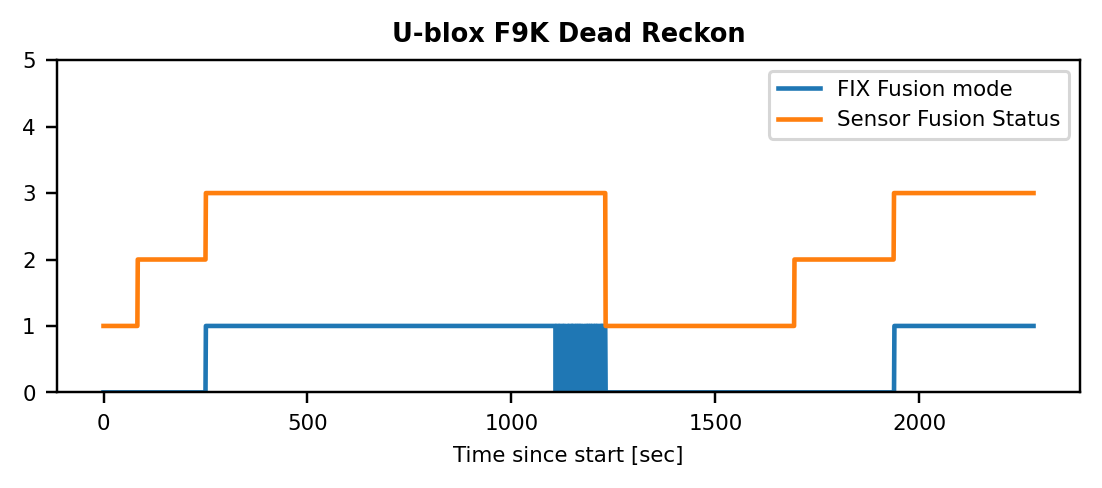

In [175]:
# Create dataframe header for processed metrics
coloum_header= ['Time since start(sec)','Galileo Time [Min]',"FIX Fusion mode","Sensor Fusion Status", "IMU Status","Acceleration [m/s^2]","x_rot [deg/s]","Latitude","Longitude"]
# Collect time step statistics
temp_row_list = []
for step in range(len(msg_collection[2])-10):
    # Galileo Time
    galTOW = parsed_metrics[0][step] /60
    # Sensor fusion mode
    fusion_mode = parsed_metrics[1][step]
    # Sensor status
    align_status = parsed_metrics[2][step]
    # IMU valid
    imu_valid = parsed_metrics[3][step]
    # x Acceleration Position
    x_accel = parsed_metrics[4][step]    
    # x Rotation rate
    x_rot = parsed_metrics[5][step]    
    # Lat Position
    lat_pos = parsed_metrics[6][step]      
    # Long Position
    lon_pos = parsed_metrics[7][step]
    # Assembly row
    time_step_stats = [step, galTOW,fusion_mode,align_status,imu_valid,x_accel,x_rot,lat_pos,lon_pos]
    # Add to temp list
    temp_row_list.append(time_step_stats)


rawx_stats=pd.DataFrame(temp_row_list,columns=coloum_header)
# Adjust time zero axis
rawx_stats["Galileo Time [Min]"]  = rawx_stats["Galileo Time [Min]"] - rawx_stats["Galileo Time [Min]"].min()
# Plot data
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 7}
plt.rc('font', **font)
#plt.rcParams["figure.figsize"] = [6.0, 4.0] 
plt.rcParams["figure.figsize"] = [6.0, 2.0] 
plt.rcParams['figure.dpi'] = 220
rawx_stats[['FIX Fusion mode','Sensor Fusion Status']].plot()
plt.title('U-blox F9K Dead Reckon', fontweight ="bold")
plt.xlabel('Time since start [sec]')
plt.ylim(0,5)
plt.show()

In [185]:
len(parsed_metrics[2])

2291

## Compare Position

In [217]:
import importlib
importlib.reload(OSNMA)
importlib.reload(time_mangement)
importlib.reload(signal_process)

testData = '24-04-2022_f9k_mk2.csv'
testData_ref = '24-04-2022_F9P.csv'

msg_collection,_= load_data(testData)
msg_collection_ref,_= load_data(testData_ref)

pos_df = signal_process.get_pos_log(msg_collection)
pos_df_ref = signal_process.get_pos_log(msg_collection_ref)

# Change coloumns name to be unique for reference 
pos_df_ref.columns = ['Time of Day[Sec]','Lat_ref','Lon_ref','Alt_ref']
pos_df.insert(1,"DR Status",parsed_metrics[2])
pos_df.insert(2,"GNSS Quality",parsed_metrics[8])



merged_pos_df=pos_df.merge(pos_df_ref, left_on='Time of Day[Sec]', right_on='Time of Day[Sec]')
merged_pos_df

,Time of Day[Sec],DR Status,GNSS Quality,Lat,Lon,Alt,Lat_ref,Lon_ref,Alt_ref
0,45154,1.0,1.0,57.639201,11.955053,1.8,57.639192,11.955099,13.0
1,45155,1.0,1.0,57.639201,11.955053,1.8,57.639192,11.955099,12.8
2,45156,1.0,1.0,57.639201,11.955053,1.8,57.639192,11.955099,12.7
3,45157,1.0,1.0,57.639201,11.955053,1.8,57.639192,11.955099,12.7
4,45158,1.0,1.0,57.639201,11.955053,1.8,57.639192,11.955099,12.7
...,...,...,...,...,...,...,...,...,...
1897,47397,3.0,1.0,57.872473,11.975551,-14.4,57.872363,11.97609,2.2
1898,47399,3.0,1.0,57.872473,11.975551,-14.4,57.872363,11.976091,2.2
1899,47400,3.0,1.0,57.872473,11.975551,-14.4,57.872363,11.976091,2.2
1900,47401,3.0,1.0,57.872473,11.975552,-14.3,57.872363,11.976092,2.2


In [241]:
def get_magnitude(earth_pos):
  ecef_pos = earth_pos.value
  # Take magnitude 
  return np.linalg.norm([*ecef_pos])


merged_pos_df=pos_df.merge(pos_df_ref, left_on='Time of Day[Sec]', right_on='Time of Day[Sec]')

# Filter (valid position)
merged_pos_df=merged_pos_df[merged_pos_df['Lat'].values!=None].reset_index(drop=True)
merged_pos_df=merged_pos_df[merged_pos_df['Lat_ref'].values!=None].reset_index(drop=True)
#merged_pos_df=merged_pos_df[-400:]

seperation = []
for row in merged_pos_df.iterrows():
  # Convert to Earth position (XYZ) on ‘WGS84’ 
  earth_pos = EarthLocation.from_geodetic(row[1]['Lon'],row[1]['Lat'],row[1]['Alt_ref'])
  earth_pos_ref = EarthLocation.from_geodetic(row[1]['Lon_ref'],row[1]['Lat_ref'],row[1]['Alt_ref'])
  # Create 3D sky points with mangitude, lat, long 
  point = SkyCoord(
    ra=row[1]['Lon']*u.degree,
    dec=row[1]['Lat']*u.degree,
    distance=get_magnitude(earth_pos)*u.meter, frame='icrs')
  point_ref = SkyCoord(
    ra=row[1]['Lon_ref']*u.degree,
    dec=row[1]['Lat_ref']*u.degree,
    distance=get_magnitude(earth_pos_ref)*u.meter, frame='icrs')
  seperation.append(point.separation_3d(point_ref).value)
merged_pos_df.insert(6,"Seperation [m]",seperation)


(1.0, 8.0)

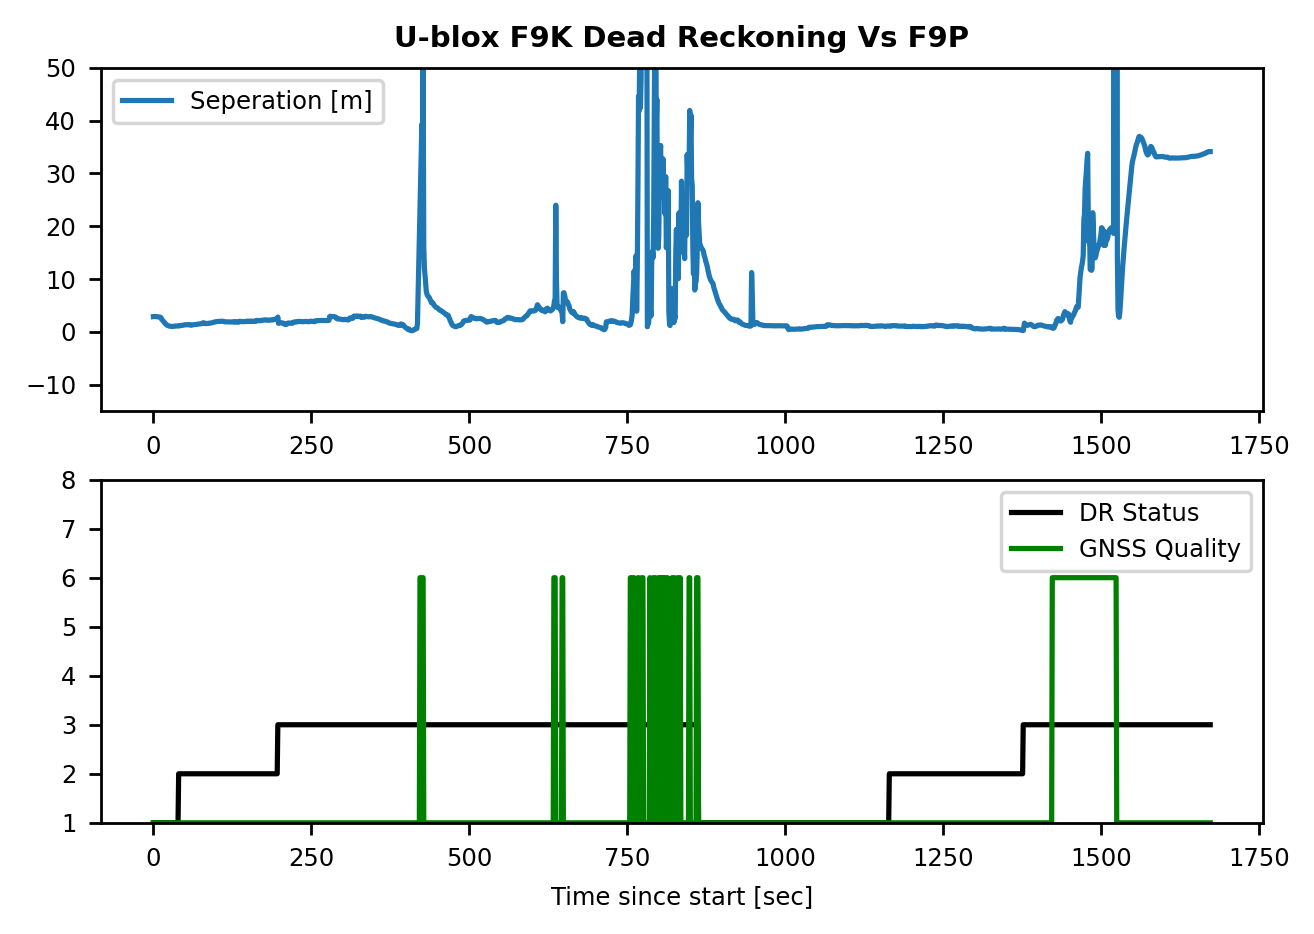

In [242]:
fig, axes = plt.subplots(2, 1)
plt.rcParams['figure.dpi'] = 250
plt.rcParams["figure.figsize"] = [6.0, 4.0] 

merged_pos_df[['Seperation [m]']].plot(ax = axes[0])
axes[0].set_title('U-blox F9K Dead Reckoning Vs F9P', fontweight ="bold")
plt.xlabel('Time since start [sec]')

axes[0].set_ylim(-15,50)

# Plot meta data
merged_pos_df[['DR Status','GNSS Quality']].plot(ax = axes[1],color=['black','green'])
plt.xlabel('Time since start [sec]')
axes[1].set_ylim(1,8)
plt.show()


In [240]:
merged_pos_df[150:300]

,Time of Day[Sec],DR Status,GNSS Quality,Lat,Lon,Alt,Seperation [m],Lat_ref,Lon_ref,Alt_ref
1424,47109,3.0,6.0,57.87018,11.981148,3.0,0.664927,57.870182,11.981158,3.9
1425,47110,3.0,6.0,57.870235,11.981071,3.0,0.678878,57.870238,11.981081,3.9
1426,47111,3.0,6.0,57.870295,11.98099,3.0,0.784946,57.870299,11.981001,4.0
1427,47114,3.0,6.0,57.87048,11.980785,2.8,1.251770,57.870486,11.980804,4.0
1428,47115,3.0,6.0,57.87054,11.980741,2.8,1.349073,57.870545,11.980762,4.1
...,...,...,...,...,...,...,...,...,...,...
1569,47277,3.0,1.0,57.872503,11.975468,-15.6,35.306358,57.872364,11.976005,2.4
1570,47278,3.0,1.0,57.872502,11.975472,-15.6,34.809426,57.872364,11.976002,2.4
1571,47279,3.0,1.0,57.872501,11.975477,-15.7,34.302805,57.872365,11.975998,2.5
1572,47280,3.0,1.0,57.8725,11.975483,-15.6,33.928639,57.872365,11.975998,2.6


In [26]:

for index, row in pos_df.iterrows():
  #print(row["Time of Day[Sec]"])
  time_step_df =pos_df_ref[pos_df_ref["Time of Day[Sec]"]==row["Time of Day[Sec]"]]
  time_step_df =pos_df_ref[pos_df_ref["Time of Day[Sec]"]==row["Time of Day[Sec]"]]

  if not time_step_df.empty:
    break
    #print(time_step_df)
  